In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import seaborn

In [3]:
loan = pd.read_csv('loan.csv', low_memory=False)
loan.head()
loan.shape

(39717, 111)

### finding data that needs clean-up

- mths_since_last_delinq	
- mths_since_last_record
- Remove % from interest rate column and convert to float
- Remove months from term
- remove year from emp length
- Remove % from revol utilization column

In [4]:
loan['int_rate'] = loan['int_rate'].replace('%', '', regex = True).astype(float)

In [5]:
loan['term'] = loan['term'].replace(' months', '', regex = True).astype(int)

In [6]:
loan['emp_length'] = loan['emp_length'].replace(' years','',regex=True)
loan['emp_length'] = loan['emp_length'].replace(' year','',regex=True)
loan['emp_length'] = loan['emp_length'].replace('\+','',regex=True)
loan['emp_length'] = loan['emp_length'].replace("< 1","0",regex=False)


In [7]:
loan['revol_util'] = loan['revol_util'].replace('%', '', regex = True).astype(float)

In [8]:
print(loan['acc_now_delinq'].value_counts())
print(loan['delinq_2yrs'].value_counts())
print(loan['delinq_amnt'].value_counts())
#print(loan[loan['mths_since_last_delinq'].isna()])


acc_now_delinq
0    39717
Name: count, dtype: int64
delinq_2yrs
0     35405
1      3303
2       687
3       220
4        62
5        22
6        10
7         4
8         2
9         1
11        1
Name: count, dtype: int64
delinq_amnt
0    39717
Name: count, dtype: int64


#### replacing na values of  mths_since_last_delinq column with 0 assuming there is no delinquency for whom data is not available. Also, converting to int post that

In [9]:
loan['mths_since_last_delinq'] = loan['mths_since_last_delinq'].fillna(0)
print(loan[~((loan['mths_since_last_delinq'].isna()) | (loan['mths_since_last_delinq']==0.0))]['loan_status'].value_counts())
loan['mths_since_last_delinq'] = loan['mths_since_last_delinq'].astype(int)
print(loan['mths_since_last_delinq'].value_counts())

loan_status
Fully Paid     11154
Charged Off     2075
Current          363
Name: count, dtype: int64
mths_since_last_delinq
0      26125
15       252
30       247
23       247
24       241
       ...  
89         1
107        1
85         1
97         1
95         1
Name: count, Length: 95, dtype: int64


### Separating month and year to do some analysis

In [10]:
loan['issue_month'] = loan['issue_d'].apply(lambda x: dt.strptime(x, "%b-%y").month)
loan['issue_year'] = loan['issue_d'].apply(lambda x: dt.strptime(x, "%b-%y").year)

### filling emp length missing values with median value

In [11]:
filtered_loan = loan[~loan['emp_length'].isna()]
filtered_loan['emp_length'] = filtered_loan['emp_length'].apply(lambda x: int(x))
print(filtered_loan['emp_length'].describe())
loan[loan['emp_length'].isna()]['emp_length'] = 4
loan['emp_length'] = loan['emp_length'].fillna(4).astype(int)
print(loan['emp_length'].describe())

count    38642.000000
mean         4.973449
std          3.562580
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64
count    39717.000000
mean         4.947101
std          3.517584
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64


C:\Users\Anshul\AppData\Local\Temp\ipykernel_11892\2149517646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loan['emp_length'] = filtered_loan['emp_length'].apply(lambda x: int(x))
C:\Users\Anshul\AppData\Local\Temp\ipykernel_11892\2149517646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan[loan['emp_length'].isna()]['emp_length'] = 4


## Checking outliers

#### Checking outliers for state

addr_state
ME       3
NE       5
IA       5
ID       6
IN       9
TN      17
MS      19
VT      54
SD      64
AK      80
WY      83
MT      85
DE     114
NH     171
HI     174
WV     177
NM     189
RI     198
DC     214
AR     245
UT     258
KS     271
OK     299
KY     325
LA     436
OR     451
AL     452
WI     460
SC     472
NV     497
MN     615
MO     686
MI     720
CT     751
NC     788
CO     792
WA     840
AZ     879
MD    1049
OH    1223
MA    1340
GA    1398
VA    1407
PA    1517
IL    1525
NJ    1850
TX    2727
FL    2866
NY    3812
CA    7099
Name: count, dtype: int64
count      50.000000
mean      794.340000
std      1212.089284
min         3.000000
5%          5.450000
10%        16.200000
25%       128.250000
50%       443.500000
75%       869.250000
95%      2803.450000
max      7099.000000
Name: count, dtype: float64
[-978.75, 1973.25]


<Axes: xlabel='addr_state', ylabel='count'>

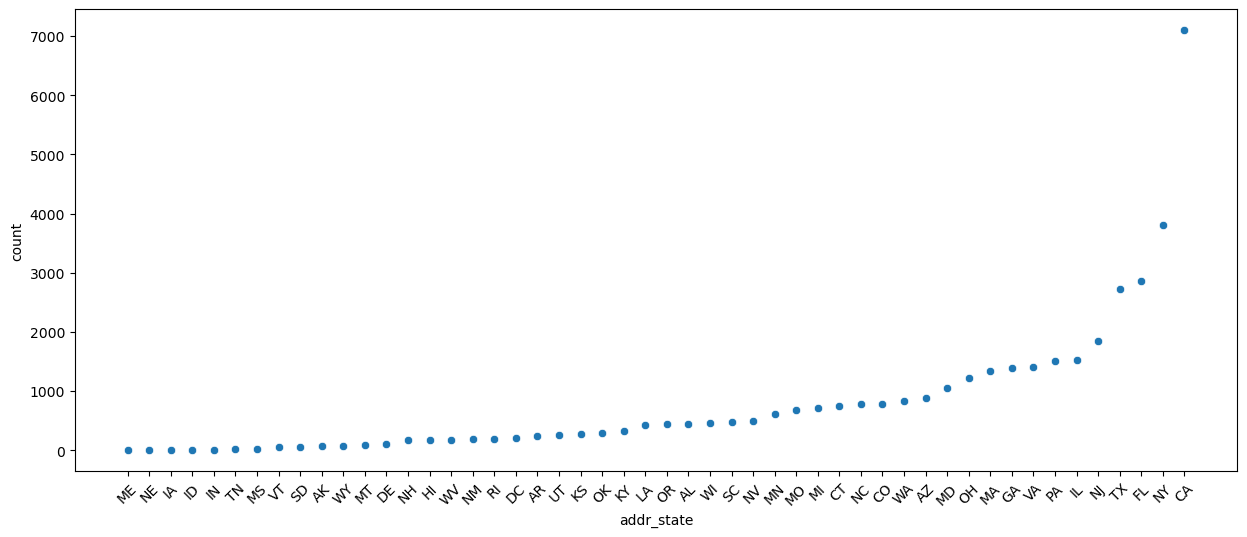

In [12]:
print(loan['addr_state'].value_counts().sort_values())
print(loan['addr_state'].value_counts().sort_values().describe(percentiles=[0.05,0.1, 0.25, 0.5, 0.75, 0.95]))
state_iqr = 866.25 - 128.25
state_outlier = [128.25 - 1.5*state_iqr, 866.25 + 1.5*state_iqr]
print(state_outlier)
plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.scatterplot(loan['addr_state'].value_counts().sort_values())

- though above scatter plot showing states having greater than 2000 as outliers, however, greater number of loans gives good mix so not removing them.
- also, it does not makes sense to consider loans less than 50, so filtering out those loans
- TX,FL, NY, CA ha maximum number of loans and should be analyzed separately

In [13]:
loans_state_filtered = loan[~loan['addr_state'].isin(['ME','NE','IA','ID','IN','TN','MS'])]


#### Checking outliers for interest rate

count    39653.000000
mean        12.022794
std          3.726704
min          5.420000
1%           5.420000
10%          7.140000
25%          9.250000
50%         11.860000
75%         14.590000
99%         20.990000
max         24.590000
Name: int_rate, dtype: float64


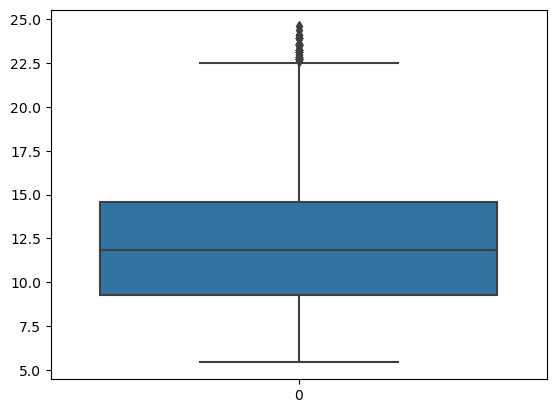

In [14]:
print(loans_state_filtered['int_rate'].describe(percentiles=[0.01,0.1, 0.25, 0.5, 0.75, 0.99]))
seaborn.boxplot(loans_state_filtered['int_rate'])
plt.show()

#### calculating outlier range using IQR

In [15]:
int_rate_iqr = 14.54 - 9.25
int_rate_outlier = [9.25 - 1.5*int_rate_iqr, 14.54 + 1.5*int_rate_iqr]
print(int_rate_outlier)

[1.3150000000000013, 22.474999999999998]


##### since lower outlier is out of range, removing higher outliers but analyzing the same before removal

In [16]:

high_int_rate_loans = loans_state_filtered[loans_state_filtered['int_rate'] > 22.47]
print(high_int_rate_loans['int_rate'].value_counts())

high_int_rate_loans.pivot_table(index=['loan_status'], values=['id'], aggfunc='count')
#seaborn.boxplot(high_int_rate_loans['int_rate'])
#plt.show()

int_rate
22.74    20
22.48    16
23.91    11
23.52     9
23.13     9
23.22     9
22.85     8
23.59     4
24.11     3
22.94     2
22.64     1
24.59     1
24.40     1
Name: count, dtype: int64


,id
loan_status,
Charged Off,37
Current,13
Fully Paid,44


#### not getting much insights from outlier and outlier is smaller in number, so it is safe to remove them

In [17]:
loan_1 = loans_state_filtered[loans_state_filtered['int_rate'] <= 22.47]

### Filtering out defaulted loans for analysis down the line

In [18]:
defaulted_loan = loan_1[loan_1['loan_status'] == 'Charged Off']
defaulted_loan.shape

(5582, 113)

In [19]:
defaulted_loan['issue_month'].value_counts()

issue_month
12    671
11    591
10    573
9     543
7     476
6     475
5     466
8     463
4     367
3     347
1     321
2     289
Name: count, dtype: int64

In [20]:
defaulted_loan['issue_year'].value_counts()

issue_year
2011    3219
2010    1485
2009     593
2008     243
2007      42
Name: count, dtype: int64

### check the distribution of loans across states

Series([], Name: count, dtype: int64)
   addr_state  loan_status   id  status_per
0          AK  Charged Off   15       19.48
1          AK   Fully Paid   62       80.52
2          AL  Charged Off   54       12.44
3          AL   Fully Paid  380       87.56
4          AR  Charged Off   27       11.49
..        ...          ...  ...         ...
81         WI   Fully Paid  377       85.88
82         WV  Charged Off   21       12.21
83         WV   Fully Paid  151       87.79
84         WY  Charged Off    4        5.06
85         WY   Fully Paid   75       94.94

[86 rows x 4 columns]


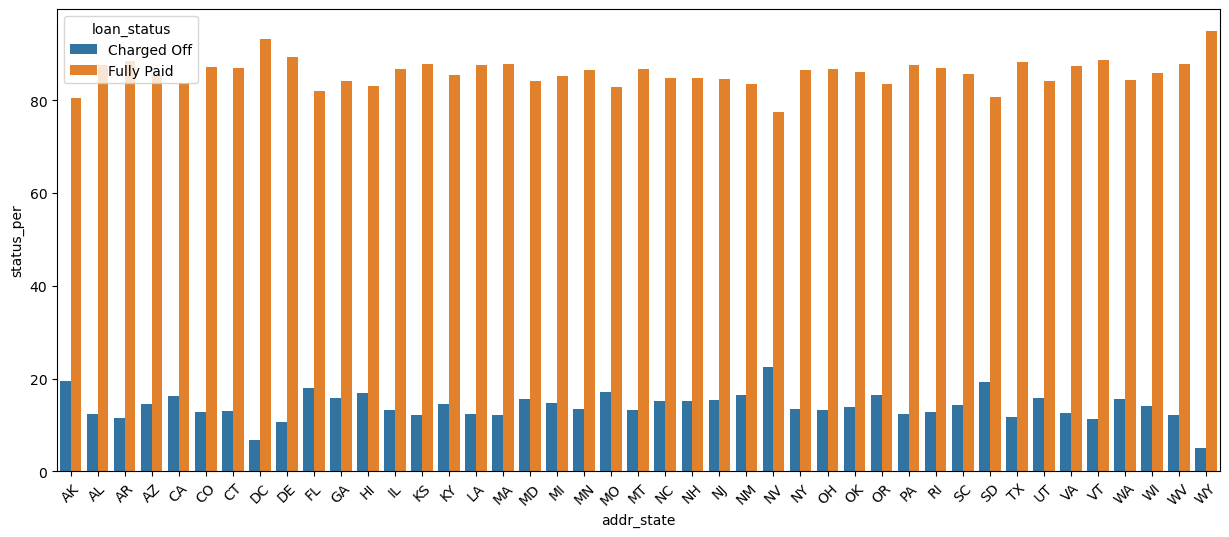

In [21]:
non_current_loans = loan_1[loan_1['loan_status'] != "Current"]
print(loan_1[loan_1['addr_state'] == 'NE']['loan_status'].value_counts())

loans_state_status = non_current_loans.groupby(['addr_state', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_state_status['status_per'] = (loans_state_status['id']*100/loans_state_status.groupby('addr_state')['id'].transform('sum')).round(2)

print(loans_state_status)
plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_state_status['addr_state'], y=loans_state_status['status_per'], hue=loans_state_status['loan_status'])

plt.show()


### correlation between percentage of loan defaulted with interest rate

## create a pivot table having loan status as column and different variables as index
- Is there a impact of verification status
- Is there a impact of employment length 
- Correlation between inq in last 6 months and loan status
- correlation between total acc and loan status
- int rate vs charged off
- bar graph for charged off as per address state
- dti relationship
- revolving line relationship
- either 36 months or 60 months has more defaults by percentage
- home ownership univariate analysis
- verification status improved  year on year? 
- univariate analysis on employment length on loans distribution
- bivariate analysis on employment length

#### verification status of defaulted loans

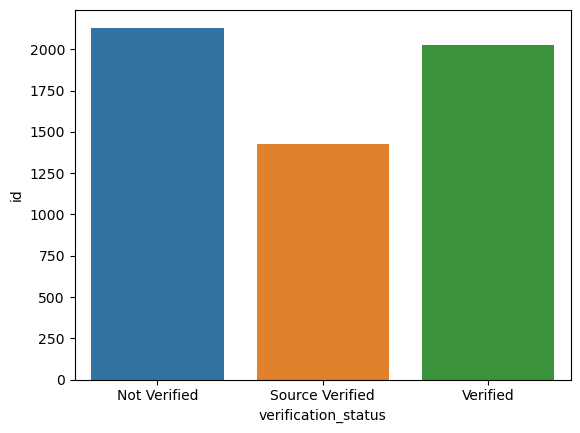

In [22]:
verification_status_defaults = defaulted_loan.pivot_table(values=['id'], index=['verification_status'],
                aggfunc='count')
seaborn.barplot(verification_status_defaults, x=verification_status_defaults.index, y=verification_status_defaults['id'])
plt.show()


#### employment length distribution on loan

In [23]:

non_current_loans_status = non_current_loans.groupby(['emp_length', 'loan_status'], as_index=False).count().iloc[:, 0:3]

#### employment length distribution on default loan

## Analyze the correlation between percentage of loan defaulted with other data
- Check the average of interest rates by grades and subgrades
- Check the average of loan_amount by grades and subgrades
- Check the average of annual_income by grades and subgrades

                    annual_inc        dti   int_rate     loan_amnt  \
grade sub_grade                                                      
A     A1          67094.570167  10.752329   5.804069   7265.795255   
      A2          66247.020644  11.528706   6.377870   7362.209688   
      A3          66382.392418  12.012977   7.163641   7888.447703   
      A4          66092.014220  12.383679   7.659537   9315.104530   
      A5          67630.288086  12.528521   8.261575   9637.910365   
B     B1          64169.648779  12.806065  10.005435   9700.209030   
      B2          67680.705338  13.048149  10.486948  10387.618809   
      B3          70436.078174  13.415394  10.982394  11387.703901   
      B4          67778.995798  13.669457  11.395436  11208.734568   
      B5          66572.046333  13.757801  11.767966  11464.147510   
C     C1          70094.167000  13.775163  12.837599  10976.035071   
      C2          67344.230928  13.779647  13.330949  11196.643339   
      C3          67

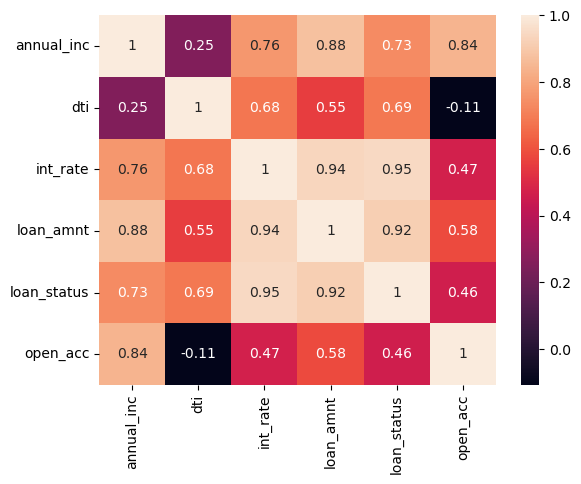

In [24]:
count_status = non_current_loans.pivot_table(index=['grade','sub_grade'], values=['int_rate', 'loan_status', 'loan_amnt', 'annual_inc', 'dti', 'open_acc']
                                             , aggfunc={'int_rate': "mean",'loan_amnt': "mean",'annual_inc': "mean",'dti':'mean','open_acc':'mean',
                                                                'loan_status': lambda x: (x.value_counts()['Charged Off']*100/x.size).round(2)},
                fill_value=0)
print(count_status)

seaborn.heatmap(count_status.corr(), annot = True)
plt.show()

#### interest rate distribution of loans and defaulted loans

In [25]:
loan.pivot_table(values=['int_rate'],columns=['loan_status'], index=['issue_year'],
                aggfunc='mean')

int_rate                      
loan_status Charged Off    Current Fully Paid
issue_year                                   
2007          11.609556        NaN  10.032524
2008          11.885830        NaN  11.018913
2009          13.121650        NaN  12.055536
2010          13.376350        NaN  11.507456
2011          14.327764  15.031465  11.626694

### Interest rate mean for defaults is increasing on year on year, however, mean for fully paid is more or less same

In [27]:
loan.groupby(['issue_year', 'loan_status'])['int_rate'].mean()

issue_year  loan_status
2007        Charged Off    11.609556
            Fully Paid     10.032524
2008        Charged Off    11.885830
            Fully Paid     11.018913
2009        Charged Off    13.121650
            Fully Paid     12.055536
2010        Charged Off    13.376350
            Fully Paid     11.507456
2011        Charged Off    14.327764
            Current        15.031465
            Fully Paid     11.626694
Name: int_rate, dtype: float64

### checking if public derogatory remarks makes any difference

In [28]:
loan['pub_rec'] = loan['pub_rec'].apply(lambda x: True if x == 1 else False)

In [29]:
loan['pub_rec_bankruptcies'] = loan['pub_rec_bankruptcies'].apply(lambda x: True if x == 1 else False)

pub_rec
True    1674
Name: count, dtype: int64
pub_rec_bankruptcies
True    1674
Name: count, dtype: int64
loan_status
Fully Paid     1271
Charged Off     366
Current          37
Name: count, dtype: int64


<Axes: xlabel='loan_status', ylabel='count'>

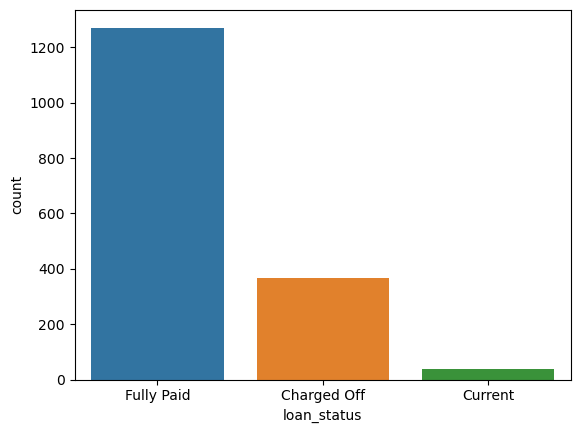

In [40]:
loan_pub_rec = loan[(loan['pub_rec'] == True) & (loan['pub_rec_bankruptcies'] == True)]
#print(loan_pub_rec.shape)
print(loan_pub_rec['pub_rec'].value_counts())
print(loan_pub_rec['pub_rec_bankruptcies'].value_counts())
print(loan_pub_rec['loan_status'].value_counts())
seaborn.barplot(loan_pub_rec, x=loan_pub_rec['loan_status'].value_counts().index, y=loan_pub_rec['loan_status'].value_counts())

#### apprx 20% people having derogatory public records, default in loans. Also, more than 80% having public derogatory records have bankruptcies

### deafaulted loan percentage with year

   issue_year  loan_status     id  status_per
0        2007  Charged Off     42       17.95
1        2007   Fully Paid    192       82.05
2        2008  Charged Off    243       15.90
3        2008   Fully Paid   1285       84.10
4        2009  Charged Off    593       12.60
5        2009   Fully Paid   4113       87.40
6        2010  Charged Off   1485       12.88
7        2010   Fully Paid  10046       87.12
8        2011  Charged Off   3219       15.75
9        2011   Fully Paid  17214       84.25


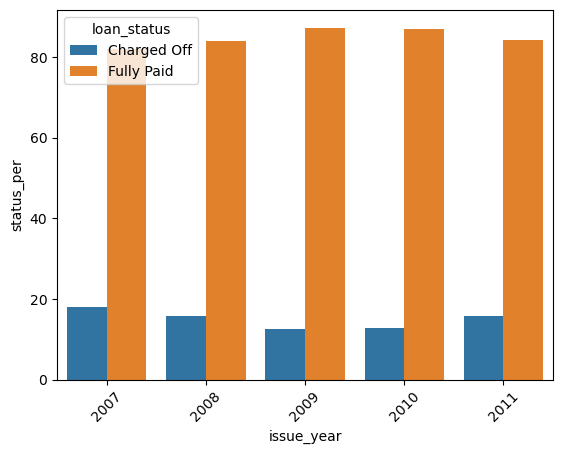

In [32]:
loans_year_status = non_current_loans.groupby(['issue_year', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_year_status['status_per'] = (loans_year_status['id']*100/loans_year_status.groupby('issue_year')['id'].transform('sum')).round(2)

print(loans_year_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_year_status['issue_year'], y=loans_year_status['status_per'], hue=loans_year_status['loan_status'])

plt.show()


#### though amount of loan increased year on year, but default percentage remains more or less same

### defaulted loan percentage with month¶

    issue_month  loan_status    id  status_per
0             1  Charged Off   321       13.52
1             1   Fully Paid  2054       86.48
2             2  Charged Off   289       12.29
3             2   Fully Paid  2062       87.71
4             3  Charged Off   347       12.94
5             3   Fully Paid  2335       87.06
6             4  Charged Off   367       13.00
7             4   Fully Paid  2456       87.00
8             5  Charged Off   466       16.01
9             5   Fully Paid  2445       83.99
10            6  Charged Off   475       15.02
11            6   Fully Paid  2688       84.98
12            7  Charged Off   476       14.25
13            7   Fully Paid  2864       85.75
14            8  Charged Off   463       13.73
15            8   Fully Paid  2910       86.27
16            9  Charged Off   543       15.57
17            9   Fully Paid  2944       84.43
18           10  Charged Off   573       15.32
19           10   Fully Paid  3168       84.68
20           

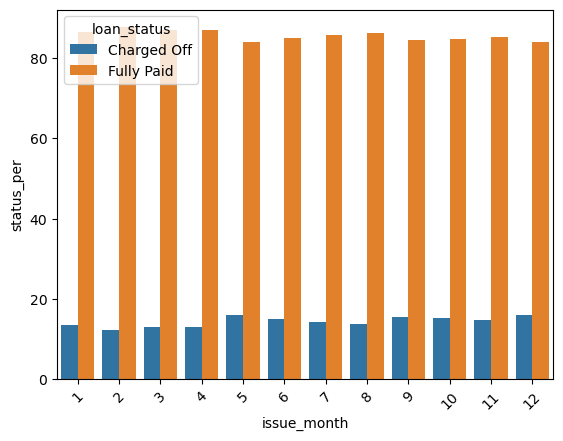

In [33]:
loans_month_status = non_current_loans.groupby(['issue_month', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_month_status['status_per'] = (loans_month_status['id']*100/loans_month_status.groupby('issue_month')['id'].transform('sum')).round(2)

print(loans_month_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_month_status['issue_month'], y=loans_month_status['status_per'], hue=loans_month_status['loan_status'])

plt.show()

### effect of home ownership on defaults

  home_ownership  loan_status     id  status_per
0       MORTGAGE  Charged Off   2309       13.62
1       MORTGAGE   Fully Paid  14650       86.38
2           NONE   Fully Paid      3      100.00
3          OTHER  Charged Off     18       18.56
4          OTHER   Fully Paid     79       81.44
5            OWN  Charged Off    440       14.84
6            OWN   Fully Paid   2524       85.16
7           RENT  Charged Off   2815       15.29
8           RENT   Fully Paid  15594       84.71


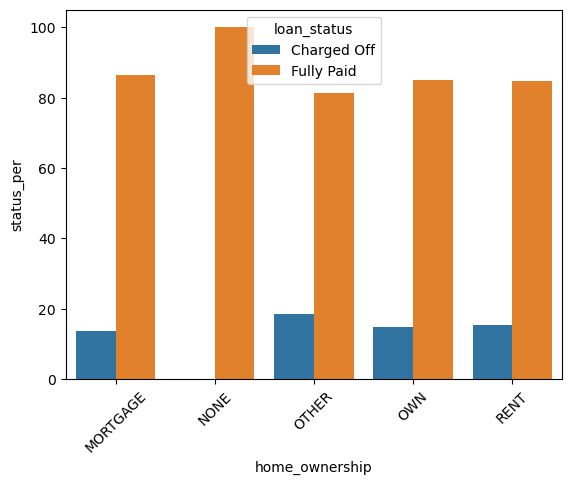

In [34]:
loans_home_status = non_current_loans.groupby(['home_ownership', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_home_status['status_per'] = (loans_home_status['id']*100/loans_home_status.groupby('home_ownership')['id'].transform('sum')).round(2)

print(loans_home_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_home_status['home_ownership'], y=loans_home_status['status_per'], hue=loans_home_status['loan_status'])

plt.show()

#### The people living on rent or have homes mortgaged have highest number of loans as compared to people have own houses.
#### However, the percentage of defaults is same across categories

### Effect of loan term with defaults

   term  loan_status     id  status_per
0    36  Charged Off   3218       11.09
1    36   Fully Paid  25812       88.91
2    60  Charged Off   2364       25.14
3    60   Fully Paid   7038       74.86


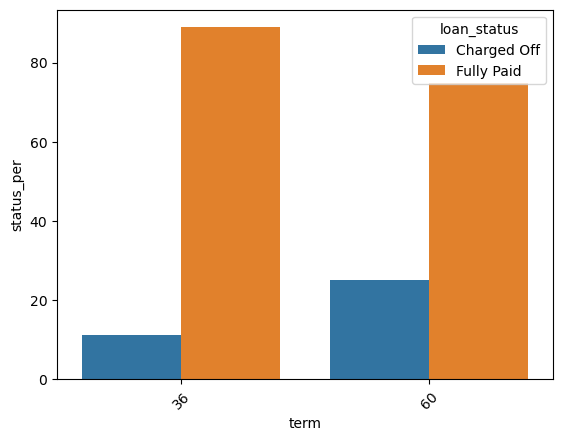

In [141]:
loans_term_status = non_current_loans.groupby(['term', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_term_status['status_per'] = (loans_term_status['id']*100/loans_term_status.groupby('term')['id'].transform('sum')).round(2)

print(loans_term_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_term_status['term'], y=loans_term_status['status_per'], hue=loans_term_status['loan_status'])

plt.show()

### Effect of emp lengths on defaults

   emp_length  loan_status    id  status_per
0      1 year  Charged Off   451       14.29
1      1 year   Fully Paid  2704       85.71
2   10+ years  Charged Off  1321       15.61
3   10+ years   Fully Paid  7142       84.39
4     2 years  Charged Off   564       13.20
5     2 years   Fully Paid  3710       86.80
6     3 years  Charged Off   546       13.66
7     3 years   Fully Paid  3450       86.34
8     4 years  Charged Off   459       13.79
9     4 years   Fully Paid  2869       86.21
10    5 years  Charged Off   454       14.28
11    5 years   Fully Paid  2726       85.72
12    6 years  Charged Off   306       14.16
13    6 years   Fully Paid  1855       85.84
14    7 years  Charged Off   262       15.38
15    7 years   Fully Paid  1442       84.62
16    8 years  Charged Off   201       14.08
17    8 years   Fully Paid  1227       85.92
18    9 years  Charged Off   158       12.89
19    9 years   Fully Paid  1068       87.11
20   < 1 year  Charged Off   632       14.09
21   < 1 y

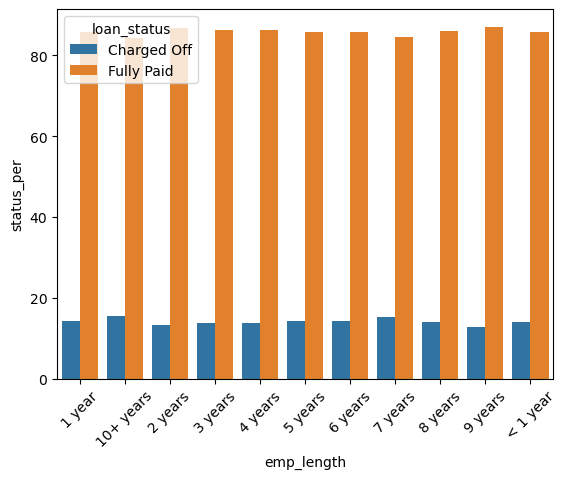

In [164]:
loans_emp_status = non_current_loans.groupby(['emp_length', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_emp_status['status_per'] = (loans_emp_status['id']*100/loans_emp_status.groupby('emp_length')['id'].transform('sum')).round(2)

print(loans_emp_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_emp_status['emp_length'], y=loans_emp_status['status_per'], hue=loans_emp_status['loan_status'])

plt.show()

### Effect of verification status of default

  verification_status  loan_status     id  status_per
0        Not Verified  Charged Off   2131       12.81
1        Not Verified   Fully Paid  14502       87.19
2     Source Verified  Charged Off   1425       14.76
3     Source Verified   Fully Paid   8228       85.24
4            Verified  Charged Off   2026       16.68
5            Verified   Fully Paid  10120       83.32


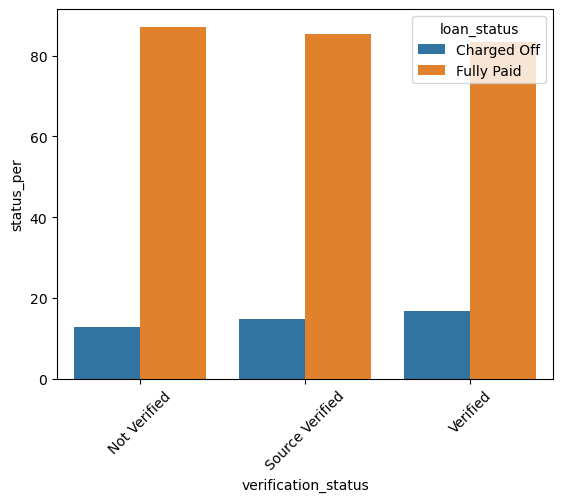

In [186]:
loans_ver_status = non_current_loans.groupby(['verification_status', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_ver_status['status_per'] = (loans_ver_status['id']*100/loans_ver_status.groupby('verification_status')['id'].transform('sum')).round(2)

print(loans_ver_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
seaborn.barplot(x=loans_ver_status['verification_status'], y=loans_ver_status['status_per'], hue=loans_ver_status['loan_status'])

plt.show()

### Effect of purpose on loan default

               purpose  loan_status     id  status_per
0                  car  Charged Off    159       10.64
1                  car   Fully Paid   1336       89.36
2          credit_card  Charged Off    538       10.74
3          credit_card   Fully Paid   4472       89.26
4   debt_consolidation  Charged Off   2740       15.24
5   debt_consolidation   Fully Paid  15239       84.76
6          educational  Charged Off     56       17.39
7          educational   Fully Paid    266       82.61
8     home_improvement  Charged Off    344       11.99
9     home_improvement   Fully Paid   2525       88.01
10               house  Charged Off     58       15.85
11               house   Fully Paid    308       84.15
12      major_purchase  Charged Off    222       10.34
13      major_purchase   Fully Paid   1924       89.66
14             medical  Charged Off    106       15.59
15             medical   Fully Paid    574       84.41
16              moving  Charged Off     92       16.00
17        

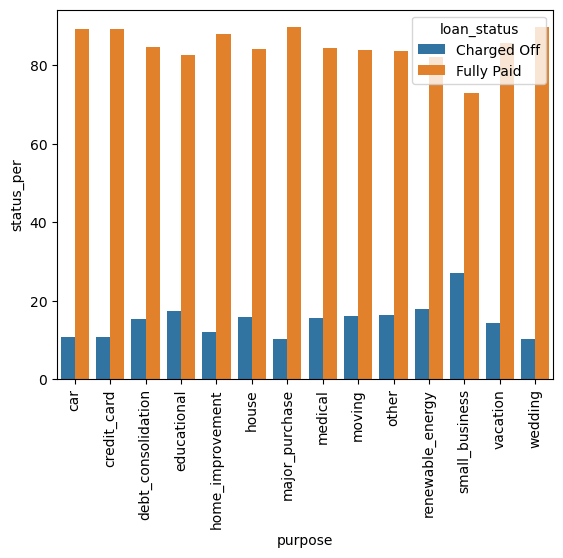

In [188]:
loans_pur_status = non_current_loans.groupby(['purpose', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_pur_status['status_per'] = (loans_pur_status['id']*100/loans_pur_status.groupby('purpose')['id'].transform('sum')).round(2)

print(loans_pur_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
seaborn.barplot(x=loans_pur_status['purpose'], y=loans_pur_status['status_per'], hue=loans_pur_status['loan_status'])

plt.show()

### correlation between number of inquiries and defaults

                inq_last_6mths        id
inq_last_6mths        1.000000 -0.889348
id                   -0.889348  1.000000


<Axes: >

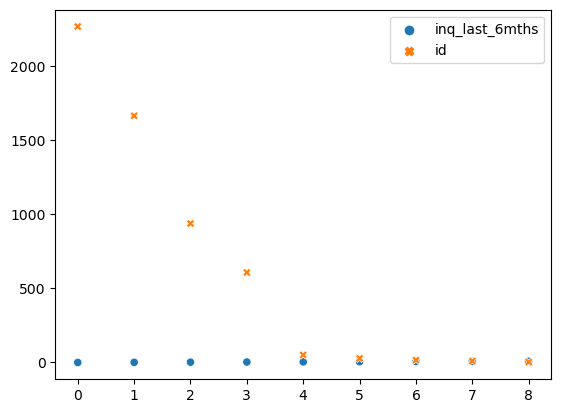

In [38]:
defaulted_loan['inq_last_6mths'].value_counts()
print(defaulted_loan.groupby(['inq_last_6mths'], as_index=False).count().iloc[:, 0:2].corr())
seaborn.scatterplot(defaulted_loan.groupby(['inq_last_6mths'], as_index=False).count().iloc[:, 0:2])

### Correlation between number of open accounts and defaults?

          open_acc        id
open_acc  1.000000 -0.805322
id       -0.805322  1.000000


<Axes: >

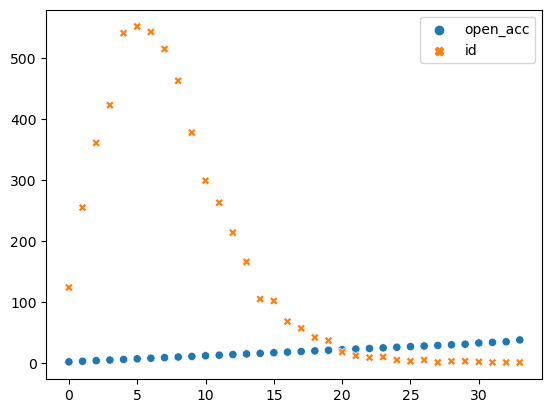

In [39]:
defaulted_loan['open_acc'].value_counts()
print(defaulted_loan.groupby(['open_acc'], as_index=False).count().iloc[:, 0:2].corr())
seaborn.scatterplot(defaulted_loan.groupby(['open_acc'], as_index=False).count().iloc[:, 0:2])

### Correlation between revol bal and Revolving utilization

In [23]:
loan['revol_util'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 39717 entries, 0 to 39716
Series name: revol_util
Non-Null Count  Dtype  
--------------  -----  
39667 non-null  float64
dtypes: float64(1)
memory usage: 310.4 KB


In [27]:
loan['revol_util'] = loan['revol_util'].fillna(loan['revol_util'].describe()['50%'])
loan['revol_util'].describe()

count    39717.000000
mean        48.832741
std         28.314798
min          0.000000
25%         25.500000
50%         49.300000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

<Axes: xlabel='revol_util_range'>

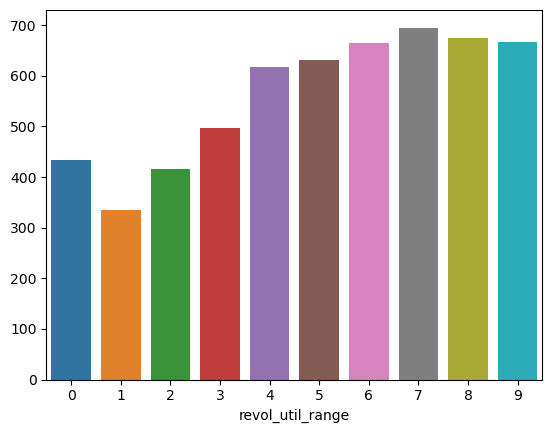

In [59]:
loan['revol_util_range'] = pd.cut(loan['revol_util'], 10, labels= np.arange(0,10))
defaulted_loan_1 = loan[loan['loan_status'] == 'Charged Off']
seaborn.barplot(x=defaulted_loan_1['revol_util_range'].value_counts().index, y=defaulted_loan_1['revol_util_range'].value_counts().values)

   revol_util_range  loan_status    id  status_per
0                 0  Charged Off   431        9.83
1                 0   Fully Paid  3955       90.17
2                 1  Charged Off   332       10.05
3                 1   Fully Paid  2971       89.95
4                 2  Charged Off   414       11.17
5                 2   Fully Paid  3292       88.83
6                 3  Charged Off   494       12.38
7                 3   Fully Paid  3495       87.62
8                 4  Charged Off   616       14.47
9                 4   Fully Paid  3642       85.53
10                5  Charged Off   626       14.98
11                5   Fully Paid  3552       85.02
12                6  Charged Off   661       16.14
13                6   Fully Paid  3434       83.86
14                7  Charged Off   692       17.77
15                7   Fully Paid  3202       82.23
16                8  Charged Off   670       18.83
17                8   Fully Paid  2889       81.17
18                9  Charged Of

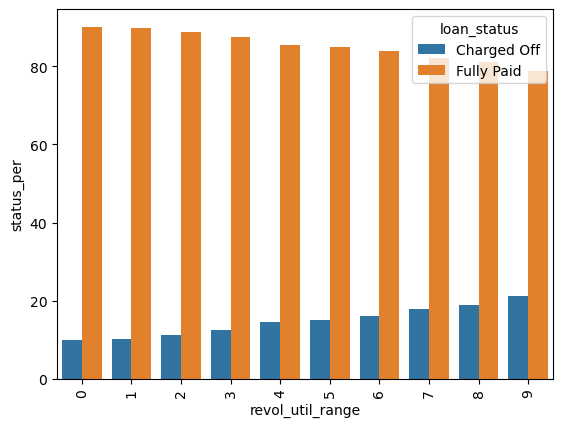

In [67]:
loans_revol_status = non_current_loans.groupby(['revol_util_range', 'loan_status'], as_index=False).count().iloc[:, 0:3]
loans_revol_status['status_per'] = (loans_revol_status['id']*100/loans_revol_status.groupby('revol_util_range')['id'].transform('sum')).round(2)

print(loans_revol_status)
#plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
seaborn.barplot(x=loans_revol_status['revol_util_range'], y=loans_revol_status['status_per'], hue=loans_revol_status['loan_status'])

plt.show()


## The defaults increases with increased revol util